In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import HistGradientBoostingRegressor, BaggingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.svm import SVR


from scipy import stats

from datetime import datetime

import random
import warnings
import pickle

%matplotlib widget

In [2]:
#First, load and transform the original df
df = pd.read_csv("./../DEAP/pollution_data.csv", dtype=object)

#remove latitude and longitude
df = df.drop(columns=["latitude", "longitude"])

#change data form (from original paper)
df["Population Staying at Home"] = df["Population Staying at Home"].apply(lambda x: x.replace(",", ""))
df["Population Not Staying at Home"] = df["Population Not Staying at Home"].apply(lambda x: x.replace(",", ""))

#update date to one-ho-encoding (from original paper)
# #df["Date"] = pd.to_datetime(df["Date"])
# df['weekday'] = df['Date'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d").weekday())
# df['month'] = df['Date'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d").month - 1)

# # using one-hot on month and weekday
# weekday_onehot = pd.get_dummies(df['weekday'])
# weekday_onehot.columns = ["day_"+str(x) for x in weekday_onehot]
# month_onehot = pd.get_dummies(df['month'])
# month_onehot.columns = ["month_"+str(x) for x in month_onehot]

# df.drop(['weekday', 'month'], axis=1, inplace=True)
# df = df.join([weekday_onehot, month_onehot])

 #keep city AQ values
# we'll mostly need median and variance values of features for most of our needs
for col in df.columns:
    for x in ["min", "max", "count", "past_week", "latitude", "longitude", "variance", "Index"]:
        if x in col:
            df.drop([col], axis=1, inplace=True)

In [3]:
df.describe(include="all")

,Date,City,County,State,Population Staying at Home,Population Not Staying at Home,mil_miles,o3_median,pressure_median,pm25_median,humidity_median,temperature_median,dew_median,no2_median,wind-speed_median,co_median,so2_median,pm10_median,wind-gust_median,pp_feat
count,35596,35596,35596,35596,35596,35596,35596,33950,34667,35134,34668,34658,20491,23558,34646,24538,14676,16965,34217,35596
unique,668,54,53,34,34412,35102,35590,390,597,181,903,592,270,283,133,168,39,111,235,1359
top,2019-01-01,albuquerque,marion,CA,203451,746566,19.147647,24.8,1015.9,25.0,0.0,0.0,21.0,3.8,2.0,2.3,1.5,10.0,4.0,0.0
freq,54,668,1327,4392,3,3,2,1026,358,2770,1206,2376,778,2031,3100,1817,6634,1459,1151,7057


In [4]:
df.shape

(35596, 20)

In [4]:
df.isnull().sum(axis = 0)[df.isnull().sum(axis = 0) != 0]

o3_median              1646
pressure_median         929
pm25_median             462
humidity_median         928
temperature_median      938
dew_median            15105
no2_median            12038
wind-speed_median       950
co_median             11058
so2_median            20920
pm10_median           18631
wind-gust_median       1379
dtype: int64

In [5]:
class City :
    def __init__(self, city_name, df = df, replace_nan_mean = True) :
        self.city_name = city_name
        self.df = df
        self.replace_nan_mean = replace_nan_mean
        self.load_city_data()
        
    
    def load_city_data(self) :
        
        city_data = self.df[self.df["City"] == self.city_name].reset_index(drop=True)
        
        #keep city metedata (city, county, state)
        self.city_metadata = city_data.loc[0, ["City", "County", "State"]]
        
        for col in city_data.columns:
            for x in ["City", "County", "State"]:
                if x in col:
                    city_data.drop([col], axis=1, inplace=True)
        
                
        columns_to_convert = city_data.columns.difference(['Date'])
        city_data[columns_to_convert] = city_data[columns_to_convert].apply(pd.to_numeric, errors='coerce')
        
        if self.replace_nan_mean :
            for col in city_data.columns:

                if col in ["pm25_median", "o3_median", "so2_median", "no2_median", "pm10_median", "co_median"]:
                    continue
                try: 
                    with warnings.catch_warnings():
                        warnings.simplefilter("ignore", category=RuntimeWarning)
                        _mean = np.nanmean(city_data[col])
                        if np.isnan(_mean) == True:
                            _mean = 0
                    
                        city_data[col] = city_data[col].fillna(_mean)
                except:
                    pass
            
        self.city_data = city_data

        #print(f'successfully loaded data for {self.city_name}')
        # print("city information")
        # print(self.city_metadata)
        # print("city data information")
        # print(self.city_data.describe())

    
    def display(self,column, prediction= None) :        
        fig = plt.figure(figsize=(10, 6))
        plt.plot(self.city_data['Date'], self.city_data[column], marker='+', linestyle='-.', c="r", label="true")
        
        if type(prediction) != type(None) :
            plt.plot(self.city_data['Date'],prediction, marker='+', linestyle='--', c="b", label="predicted")

        plt.title(f'{column} evolution')
        plt.xlabel('Date')
        plt.ylabel(column)
        plt.grid(True)
        plt.show()



In [6]:
austin = City("austin")

In [7]:
austin.city_data.head()

,Date,Population Staying at Home,Population Not Staying at Home,mil_miles,o3_median,pressure_median,pm25_median,humidity_median,temperature_median,dew_median,...,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11
0,2019-01-01,268732,976194,27.286079,11.2,1021.2,38.0,85.7,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
1,2019-01-02,207652,1037274,36.321465,16.8,1019.1,21.0,92.3,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
2,2019-01-03,200295,1044631,37.852353,6.4,1016.2,52.0,88.6,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
3,2019-01-04,219538,1025388,44.376700,27.2,1023.8,19.0,59.0,9.5,0.0,...,False,False,False,False,False,False,False,False,False,False
4,2019-01-05,197964,1046962,42.266993,17.6,1011.2,53.0,86.5,24.4,0.0,...,False,False,False,False,False,False,False,False,False,False


In [8]:
austin.city_data.isnull().sum(axis = 0)[austin.city_data.isnull().sum(axis = 0) != 0]

o3_median        3
pm25_median      6
no2_median     623
co_median      666
so2_median     628
pm10_median    666
dtype: int64

In [9]:
class Training :
    def __init__(self, city: City, objective_data, model = None) :
        self.objective_data = objective_data
        self.city = city
        self.model = model
        no_nan_city_data = self.city.city_data[~self.city.city_data[self.objective_data].isna()].reset_index(drop=True)
        self.y = no_nan_city_data[self.objective_data]
        self.X = no_nan_city_data.drop(columns = ["o3_median", "pm25_median", "no2_median", "co_median", "so2_median", "pm10_median"])
        self.dates = no_nan_city_data["Date"]
        
        
    def train(self) :
        self.model.fit(self.X, self.y)
    
    def test(self) :
        self.y_pred = self.model.predict(self.X)
        print(mean_squared_error(self.y_pred, self.y))
        self.display()
    
    def display(self) :        
        fig = plt.figure(figsize=(10, 6))
        plt.plot(self.dates, self.y, marker='+', linestyle='-.', c="r", label="true")
        plt.plot(self.dates,self.y_pred, marker='+', linestyle='--', c="b", label="predicted")

        plt.title(f'{self.objective_data} evolution')
        plt.xlabel('Date')
        plt.ylabel(self.objective_data)
        plt.grid(True)
        plt.show()
        

In [10]:
t = Training(austin, "pm25_median")

In [11]:
t.X.shape

(660, 30)

In [12]:
with open("./clusters/X_dens_clust.pkl", 'rb') as file :    
    X_dens_clust = pickle.load(file)
with open("./clusters/all_cities.pkl", 'rb') as file :    
    all_cities = pickle.load(file)

In [13]:
all_cities

,City
0,albuquerque
1,atlanta
2,austin
3,baltimore
4,boise
5,boston
7,charlotte
8,chicago
9,columbia
10,columbus


In [14]:
with open("./clusters/X_dens_clust.pkl", 'rb') as file :    
    X_dens_clust = pickle.load(file)
X_dens_clust_0 = X_dens_clust[["City"]][X_dens_clust["cluster"] == 0]
X_dens_clust_1 = X_dens_clust[["City"]][X_dens_clust["cluster"] == 1]
X_dens_clust_2 = X_dens_clust[["City"]][X_dens_clust["cluster"] == 2]

In [15]:
X_train, X_test = train_test_split(X_dens_clust_0, test_size=0.15, random_state=42)
print(X_train.shape, X_test.shape)

(25, 1) (5, 1)


In [16]:
# training over all the cities of density group 0 (low density, low urban area density)

class groupCity() :
    def __init__(self, cities_group, objective_data, scale_data = False, scale_target = False, handle_nan = False) :
        self.cities_group = cities_group
        self.test_set_size = 60
        self.X_train = pd.DataFrame()
        self.y_train = pd.DataFrame()
        self.X_test = pd.DataFrame()
        self.y_test = pd.DataFrame()
        self.X_test_date = pd.DataFrame()
        self.X_train_date = pd.DataFrame()
        self.objective_data = objective_data
        self.scale_data = scale_data
        self.scale_target = scale_target
        self.handle_nan = handle_nan
        #self.city_train_test_split()
       
        
    def city_train_test_split(self) :
        self.train_cities, self.test_cities = train_test_split(self.cities_group, test_size=0.15, random_state=42)
    
    

    def make_dataset(self) :
        for i in self.cities_group["City"] :
            city = City(i)
            city_training = Training(city, self.objective_data)
            if self.handle_nan :
                city_training.X.loc[:, ~city_training.X.columns.str.contains('day|month') & (city_training.X.columns != 'Date')] = city_training.X.loc[:, ~city_training.X.columns.str.contains('day|month') & (city_training.X.columns != 'Date')].interpolate(axis = 1)
                city_training.y = city_training.y.interpolate()
                  
            #remove outliers
            
            city_training.y = city_training.y.to_frame()
            city_training.y['zscore'] = stats.zscore(city_training.y[self.objective_data])
            filtered_y = city_training.y[abs(city_training.y['zscore']) <= 2].reset_index(drop=True)
            filtered_X = city_training.X[abs(city_training.y['zscore']) <= 2].reset_index(drop=True)

            filtered_y = filtered_y.drop(columns=['zscore'])

            #print("data before removing outliers",filtered_y.shape,filtered_X.shape)
            #print("data after removing outliers",filtered_y.shape,filtered_X.shape)
            
            test_index_start = random.randint(0, filtered_X.shape[0] - self.test_set_size)

            
            self.X_test = pd.concat([self.X_test, filtered_X.iloc[test_index_start:test_index_start + self.test_set_size].drop(columns=["Date"])]).reset_index(drop=True)
            self.X_test_date = pd.concat([self.X_test_date,filtered_X.iloc[test_index_start:test_index_start + self.test_set_size]["Date"]]).reset_index(drop=True)
            self.y_test = pd.concat([self.y_test, filtered_y.iloc[test_index_start:test_index_start + self.test_set_size]]).reset_index(drop=True)
            self.X_train = pd.concat([self.X_train, filtered_X.drop(index=list(range(test_index_start, test_index_start + self.test_set_size))).drop(columns=["Date"])]).reset_index(drop=True)
            self.X_train_date = pd.concat([self.X_train_date,filtered_X.drop(index=list(range(test_index_start, test_index_start + self.test_set_size)))["Date"]]).reset_index(drop=True)
            self.y_train = pd.concat([self.y_train, filtered_y.drop(index=list(range(test_index_start, test_index_start + self.test_set_size)))]).reset_index(drop=True)
      
        self.feature_names = self.X_test.columns
        
        
        if self.scale_data :
            self.scale_city_data()
        if self.scale_target : 
            self.scale_city_target()
        
        # print(self.y_test)
        # self.y_test = self.y_test[0]
        # self.y_train = self.y_train[0]
        
    def scale_city_data(self) :
        self.X_scaler = StandardScaler()
        self.X_scaler.fit(pd.concat([self.X_train, self.X_test]))
        self.X_train = self.X_scaler.transform(self.X_train)
        self.X_test = self.X_scaler.transform(self.X_test)
    
    def scale_city_target(self) :
        self.y_scaler = StandardScaler()
        self.y_scaler.fit(pd.concat([self.y_train, self.y_test]))
        self.y_train = self.y_scaler.transform(self.y_train)
        self.y_test = self.y_scaler.transform(self.y_test)
        
    def find_best_parameters_fit(self, model, param_grid) :
        X_train = self.X_train
        model = GridSearchCV(model,param_grid).fit(X_train, self.y_train.values.ravel())
        print(model.best_estimator_)
        return model
    
    def train(self, model) :
        X_train = self.X_train
        model.fit(X_train, self.y_train.values.ravel())
        return model
    
    def test(self, model, display= False) :
        
        self.y_pred = model.predict(self.X_test)
        print("rmse", mean_squared_error(self.y_pred, self.y_test, squared=False))
        print("MAPE", mean_absolute_percentage_error(self.y_pred, self.y_test))
        if display :
            self.display()
    
    def display(self) :
        
        self.display_index = random.sample(range(self.X_test.shape[0]//60), 5)

        for city_index in self.display_index :
            fig = plt.figure(figsize=(10, 4))
            plt.plot(self.X_test_date[0][60*city_index:60*(city_index+1) ], self.y_test[60*city_index:60*(city_index+1) ], marker='+', linestyle='-.', c="r", label="true")
            plt.plot(self.X_test_date[0][60*city_index:60*(city_index+1) ],self.y_pred[60*city_index:60*(city_index+1) ], marker='+', linestyle='--', c="b", label="predicted")

            plt.title(f'{self.objective_data} evolution')
            plt.xlabel('Date')
            plt.ylabel(self.objective_data)
            plt.grid(True)
            plt.show()
    
    def evaluate_feature_importance(self, model, display = False) :
        r = permutation_importance(model, self.X_test, self.y_test, n_repeats=30, random_state=0)
        
        for i in r.importances_mean.argsort()[::-1]:
            if r.importances_mean[i] - r.importances_std[i] > 0:
                print(f"{self.feature_names[i]:<8}" f" "
                    f"{r.importances_mean[i]:.3f}"
                    f" +/- {r.importances_std[i]:.3f}")
        
        if display :
            self.plot_permutation_importance(r.importances_mean, r.importances_std)
    
    def plot_permutation_importance(self, importances_mean, importances_std):
        # Sort features based on mean importance
        sorted_indices = importances_mean.argsort()[::-1]

        # Determine the number of features to plot (up to 10)
        num_features_to_plot = min(len(self.feature_names), 10)

        # Bar plot for feature importances with inverted axes
        plt.figure(figsize=(10, min(6, num_features_to_plot * 0.6)))
        bars = plt.barh(range(num_features_to_plot), importances_mean[sorted_indices[:num_features_to_plot]], xerr=importances_std[sorted_indices[:num_features_to_plot]], align="center")
        
        # Rotate y-axis tick labels
        plt.yticks(range(num_features_to_plot), [self.feature_names[i] for i in sorted_indices[:num_features_to_plot]], rotation=0, ha="right")
        
        # Add value annotations on the right side of the bars
        for bar, importance_mean in zip(bars, importances_mean[sorted_indices[:num_features_to_plot]]):
            plt.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height() / 2 + 0.3, f'{importance_mean:.3f}', va='center')

        plt.ylabel('Features')
        plt.xlabel('Importance')
        plt.title('Permutation Importance of Features')
        plt.tight_layout()
        plt.show()

In [54]:
all_cities_group = groupCity(all_cities, "pm25_median", handle_nan=True)
all_cities_group.make_dataset()

In [55]:
#HistGradientBoostingRegressor(max_iter=150, max_leaf_nodes=10)

GBR = HistGradientBoostingRegressor(loss="absolute_error", max_iter=300, max_leaf_nodes=40, min_samples_leaf=5)
param_grid = {'max_leaf_nodes': [10,20,30,40], 'max_iter': [100,150,200,250,300],"min_samples_leaf": [5,10,20,30]}
#GBR = group_city_0.find_best_parameters_fit(GBR, param_grid)
GBR = all_cities_group.train(GBR)


rmse 10.967578962584787
MAPE 0.3011261716286195


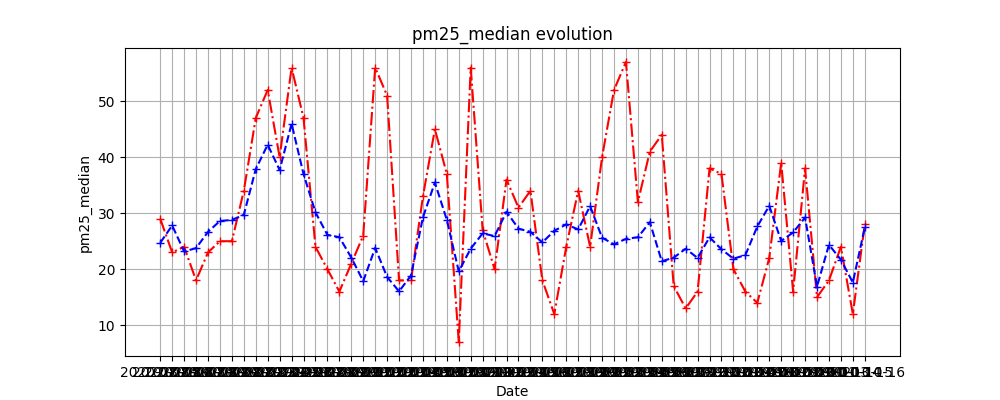

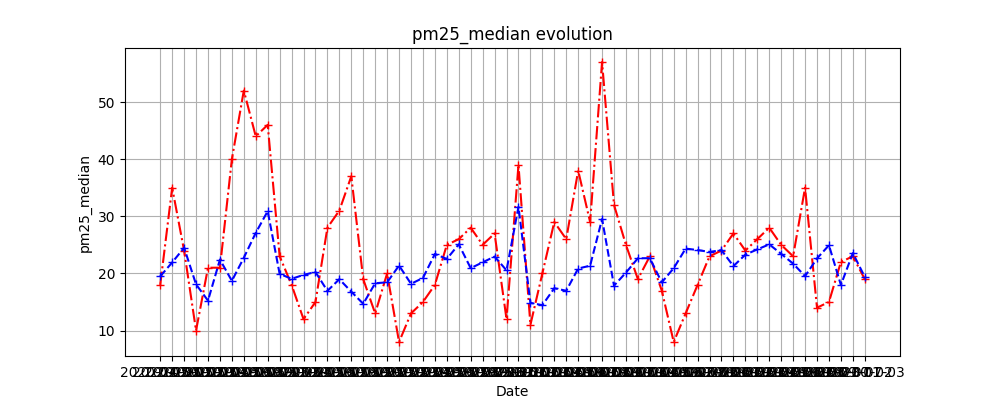

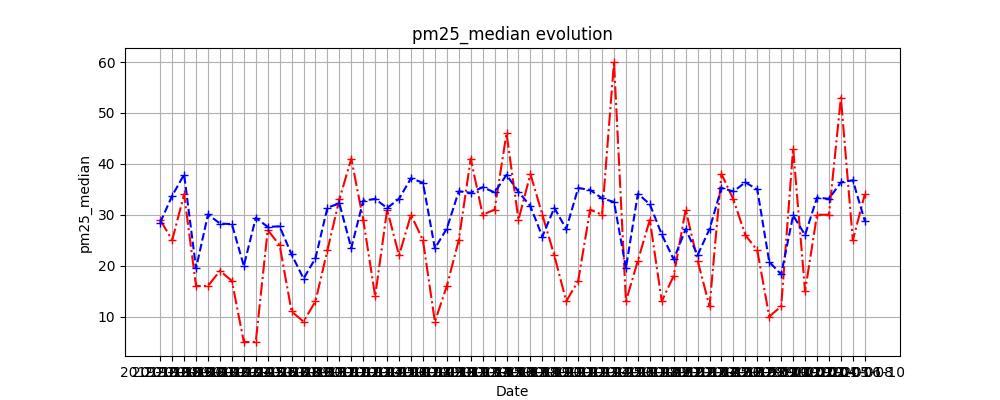

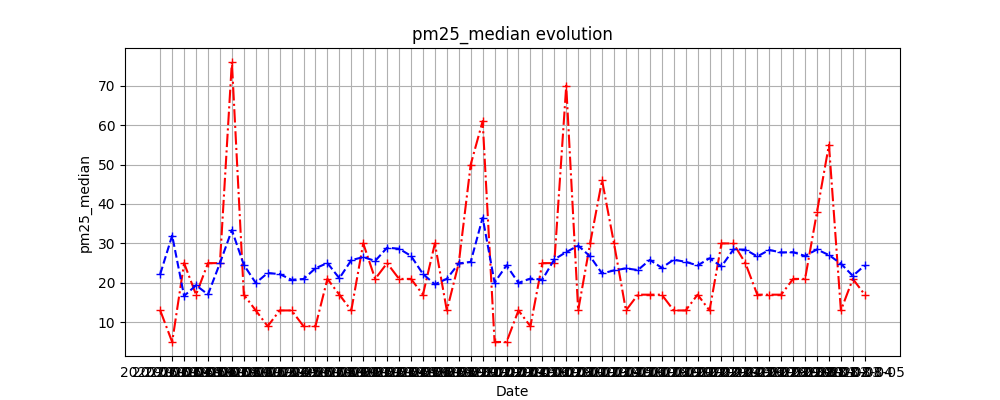

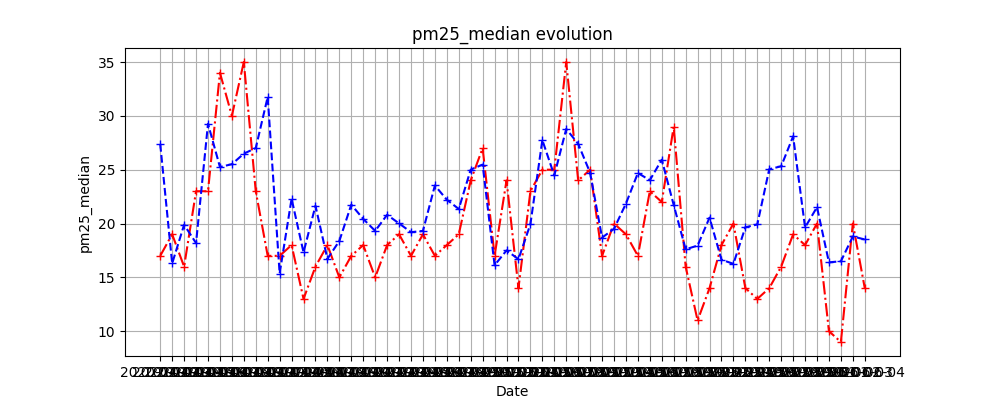

In [56]:
all_cities_group.test(GBR, display=True)


In [26]:
group_city_0 = groupCity(X_dens_clust_0, "pm25_median", handle_nan=True)
group_city_0.make_dataset()

In [27]:
#HistGradientBoostingRegressor(max_iter=150, max_leaf_nodes=10)

GBR = HistGradientBoostingRegressor(loss="absolute_error", max_iter=300, max_leaf_nodes=40, min_samples_leaf=5)
param_grid = {'max_leaf_nodes': [10,20,30,40], 'max_iter': [100,150,200,250,300],"min_samples_leaf": [5,10,20,30]}
#GBR = group_city_0.find_best_parameters_fit(GBR, param_grid)
GBR = group_city_0.train(GBR)


In [28]:
group_city_0.test(GBR)


rmse 9.799320093972337
MAPE 0.27308632388772713


In [29]:
group_city_0.evaluate_feature_importance(GBR)

KeyboardInterrupt: 

In [30]:
bg = BaggingRegressor(n_estimators=120, max_samples=120)
param_grid = {'n_estimators': [10,20,30,40, 50, 75, 100, 120], 'max_samples': [1, 5, 10, 50, 100, 120, 150]}
#bg = group_city_0.find_best_parameters_fit(bg, param_grid)
bg = group_city_0.train(bg)

In [31]:
group_city_0.test(bg)

rmse 10.539898689761305
MAPE 0.28817952576571415


In [32]:
dt = DecisionTreeRegressor()
#param_grid = {'n_estimators': [10,20,30,40, 50, 75, 100, 120], 'max_samples': [1, 5, 10, 50, 100, 120, 150]}
#group_city_0.find_best_parameters_fit(param_grid)
dt = group_city_0.train(dt)

In [33]:
group_city_0.test(dt)

rmse 14.083560155964353
MAPE 0.4006912607812865


In [24]:
group_city_0 = groupCity(X_dens_clust_0, "pm25_median", scale_data=True, scale_target=True)
group_city_0.make_dataset()


In [23]:
svm = SVR()
#param_grid = {'n_estimators': [10,20,30,40, 50, 75, 100, 120], 'max_samples': [1, 5, 10, 50, 100, 120, 150]}
#group_city_0.find_best_parameters_fit(param_grid)
svm = group_city_0.train(svm)

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [87]:
group_city_0.test(svm)

rmse 12.227812886261432
score -0.019062958377587425


In [ ]:
group_city_0 = groupCity(X_dens_clust_0, "pm25_median", scale_data=True, scale_target=True)
group_city_0.make_dataset()


In [77]:

# Convert to PyTorch tensors
X_train = torch.tensor(group_city_0.X_train, dtype=torch.float32)
X_test = torch.tensor(group_city_0.X_test, dtype=torch.float32)
y_train = torch.tensor(np.array(group_city_0.y_train), dtype=torch.float32).view(-1, 1)  # Reshape to (num_samples, 1)
y_test = torch.tensor(np.array(group_city_0.y_test), dtype=torch.float32).view(-1, 1)  # Reshape to (num_samples, 1)

In [247]:

# Step 3: Define the PyTorch model
class RegressionModel(nn.Module):
    def __init__(self, input_size):
        super(RegressionModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)  # Adjust the hidden layer size as needed
        self.relu = nn.ReLU()  # Adjust the hidden layer size as needed
        self.fc2 = nn.Linear(64, 1)  # Output layer with 1 neuron for regression

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)  
        x = self.fc2(x)
        return x

# Create an instance of the model
input_size = 29
model = RegressionModel(input_size)

# Step 4: Define loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error Loss for regression
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Adjust the learning rate as needed

# Step 5: Train the model
num_epochs = 75  # Adjust the number of epochs as needed
batch_size = 32  # Adjust the batch size as needed

train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Step 6: Evaluate the model on the test set
model.eval()
with torch.no_grad():
    predictions = model(X_test)
    test_loss = criterion(predictions, y_test)
    print(f'Test Loss: {test_loss.item():.4f}')


Epoch [1/75], Loss: 983.7810
Epoch [2/75], Loss: 847.0826
Epoch [3/75], Loss: 881.3864
Epoch [4/75], Loss: 644.2114
Epoch [5/75], Loss: 781.3525
Epoch [6/75], Loss: 282.4142
Epoch [7/75], Loss: 117.9971
Epoch [8/75], Loss: 123.0358
Epoch [9/75], Loss: 66.9958
Epoch [10/75], Loss: 106.5018
Epoch [11/75], Loss: 120.0152
Epoch [12/75], Loss: 283.3567
Epoch [13/75], Loss: 206.0164
Epoch [14/75], Loss: 185.1294
Epoch [15/75], Loss: 103.3870
Epoch [16/75], Loss: 86.2122
Epoch [17/75], Loss: 146.1543
Epoch [18/75], Loss: 140.0799
Epoch [19/75], Loss: 126.3123
Epoch [20/75], Loss: 115.9389
Epoch [21/75], Loss: 157.5534
Epoch [22/75], Loss: 94.4277
Epoch [23/75], Loss: 133.3488
Epoch [24/75], Loss: 227.1813
Epoch [25/75], Loss: 147.9210
Epoch [26/75], Loss: 113.4311
Epoch [27/75], Loss: 127.9140
Epoch [28/75], Loss: 147.5582
Epoch [29/75], Loss: 92.9012
Epoch [30/75], Loss: 212.2575
Epoch [31/75], Loss: 174.3329
Epoch [32/75], Loss: 86.8072
Epoch [33/75], Loss: 55.6699
Epoch [34/75], Loss: 153.

<h1>Now we know what model to use</h1>

<h2>Density clusters</h2>

In [19]:
with open("./clusters/X_dens_clust.pkl", 'rb') as file :    
    X_dens_clust = pickle.load(file)
X_dens_clust_0 = X_dens_clust[["City"]][X_dens_clust["cluster"] == 0]
X_dens_clust_1 = X_dens_clust[["City"]][X_dens_clust["cluster"] == 1]
X_dens_clust_2 = X_dens_clust[["City"]][X_dens_clust["cluster"] == 2]
density_clusters = [X_dens_clust_0, X_dens_clust_1, X_dens_clust_2]

In [23]:
def get_final_feature_importance(cluster, objective_data) :
    group_city_0 = groupCity(cluster, objective_data, handle_nan=True)
    group_city_0.make_dataset()
    print("mean",group_city_0.y_train.mean())
    # GBR = HistGradientBoostingRegressor(loss="absolute_error", max_iter=300, max_leaf_nodes=40, min_samples_leaf=5)
    # GBR = group_city_0.train(GBR)
    # print("test results")
    # group_city_0.test(GBR)
    # print(" ")
    # print("features importance")
    # group_city_0.evaluate_feature_importance(GBR, display=True)

-------------------
density_cluster_0
 
pm25_median mean pm25_median    29.887914
dtype: float64
test results
rmse 10.723020848138688
MAPE 0.2927464147200507
 
features importance
temperature_median 0.264 +/- 0.018
humidity_median 0.109 +/- 0.011
wind-gust_median 0.063 +/- 0.008
Population Staying at Home 0.044 +/- 0.006
mil_miles 0.041 +/- 0.006
Population Not Staying at Home 0.040 +/- 0.006
dew_median 0.033 +/- 0.006
pp_feat  0.027 +/- 0.007
pressure_median 0.025 +/- 0.006
wind-speed_median 0.020 +/- 0.003
month_10 0.005 +/- 0.002
month_2  0.004 +/- 0.003
month_4  0.004 +/- 0.002
month_9  0.002 +/- 0.001
month_3  0.002 +/- 0.001
month_8  0.002 +/- 0.001
month_0  0.001 +/- 0.000
month_5  0.001 +/- 0.001
month_1  0.001 +/- 0.001
day_6    0.001 +/- 0.001
day_2    0.001 +/- 0.001


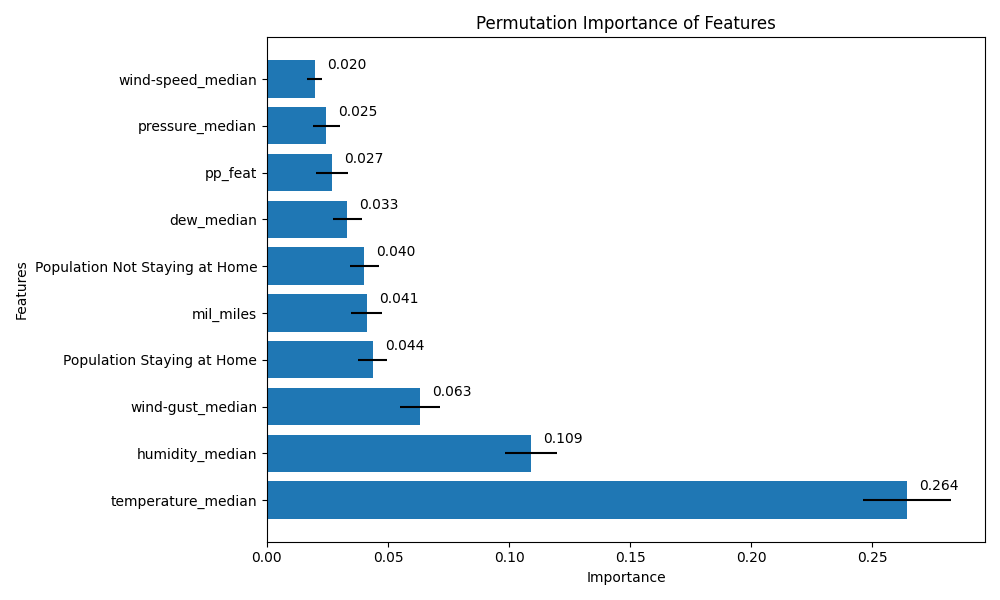

 
-------------------
density_cluster_1
 
pm25_median mean pm25_median    29.322428
dtype: float64
test results
rmse 11.313827082155843
MAPE 0.28377065469228957
 
features importance
Population Not Staying at Home 0.163 +/- 0.016
wind-gust_median 0.162 +/- 0.016
dew_median 0.134 +/- 0.010
wind-speed_median 0.083 +/- 0.014
humidity_median 0.079 +/- 0.011
temperature_median 0.073 +/- 0.012
mil_miles 0.052 +/- 0.007
pp_feat  0.051 +/- 0.008
pressure_median 0.023 +/- 0.006
Population Staying at Home 0.021 +/- 0.005
month_7  0.005 +/- 0.002
month_8  0.003 +/- 0.003


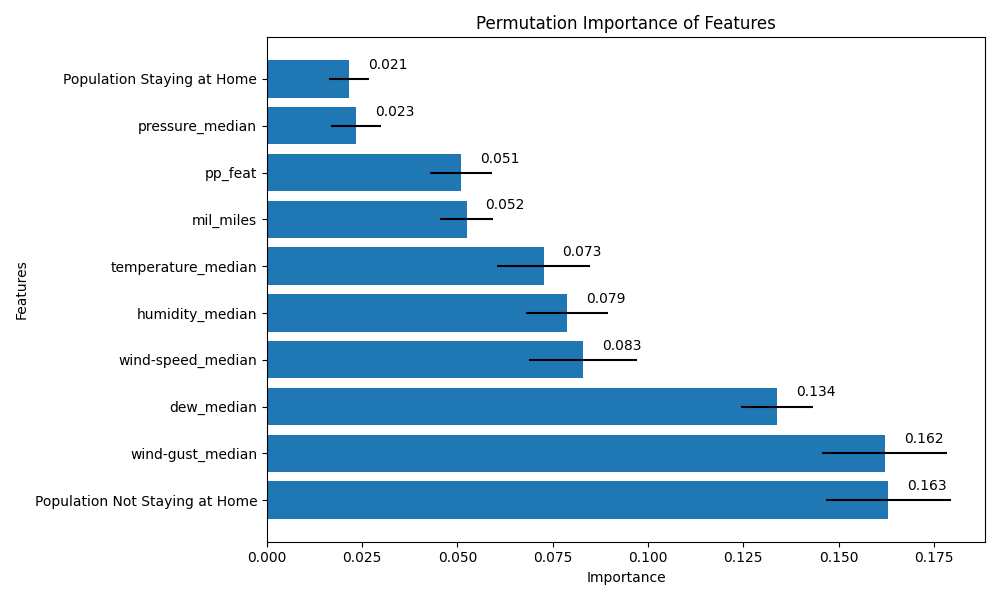

 
-------------------
density_cluster_2
 
pm25_median mean pm25_median    28.955272
dtype: float64
test results
rmse 9.424243349475054
MAPE 0.2613832189460931
 
features importance
temperature_median 0.307 +/- 0.040
humidity_median 0.077 +/- 0.015
wind-gust_median 0.047 +/- 0.013
wind-speed_median 0.031 +/- 0.012
pressure_median 0.029 +/- 0.013
Population Not Staying at Home 0.027 +/- 0.011
pp_feat  0.012 +/- 0.008
dew_median 0.011 +/- 0.006
day_5    0.004 +/- 0.001
day_6    0.004 +/- 0.002
month_8  0.004 +/- 0.001
day_0    0.003 +/- 0.003
day_4    0.003 +/- 0.002
day_3    0.003 +/- 0.002
month_7  0.002 +/- 0.002


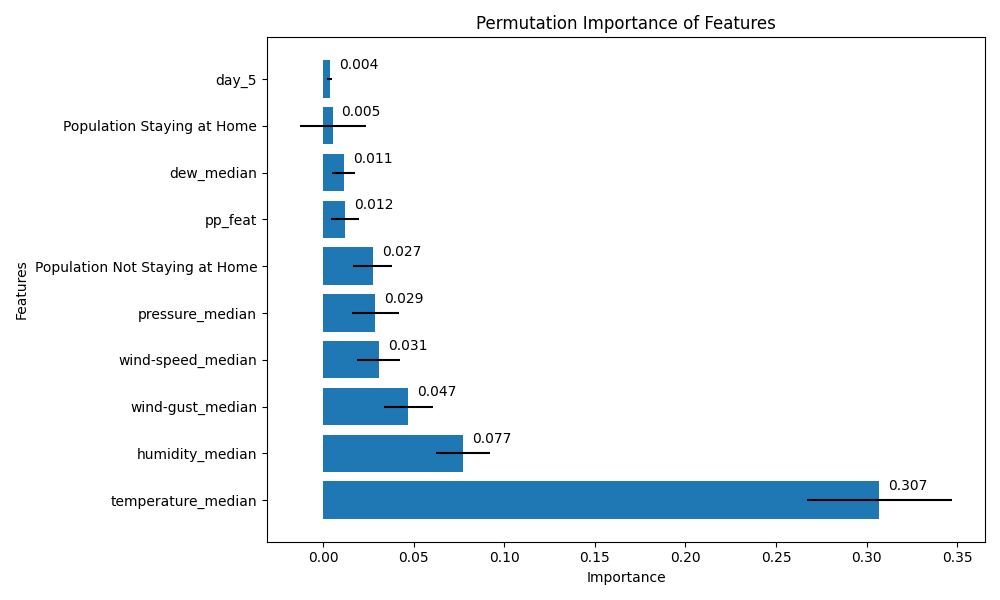

In [20]:
for i,cluster in enumerate(density_clusters) :
    print("-------------------")
    print(f"density_cluster_{i}")
    print(" ")
    get_final_feature_importance(cluster, "pm25_median")
    print(" ")


<h2>population clusters</h2>

In [21]:
with open("./clusters/X_pop_clust.pkl", 'rb') as file :    
    X_pop_clust = pickle.load(file)
X_pop_clust_0 = X_pop_clust[["City"]][X_pop_clust["cluster"] == 0]
X_pop_clust_1 = X_pop_clust[["City"]][X_pop_clust["cluster"] == 1]
X_pop_clust_2 = X_pop_clust[["City"]][X_pop_clust["cluster"] == 2]
X_pop_clust_3 = X_pop_clust[["City"]][X_pop_clust["cluster"] == 3]
population_clusters = [X_pop_clust_0, X_pop_clust_1, X_pop_clust_2, X_pop_clust_3]

In [24]:
for i,cluster in enumerate(population_clusters) :
    print("-------------------")
    print(f"pop_cluster_{i}")
    print(" ")
    get_final_feature_importance(cluster, "pm25_median")
    print(" ")


-------------------
pop_cluster_0
 
mean pm25_median    27.618426
dtype: float64
 
-------------------
pop_cluster_1
 
mean pm25_median    38.319955
dtype: float64
 
-------------------
pop_cluster_2
 
mean pm25_median    29.771412
dtype: float64
 
-------------------
pop_cluster_3
 
mean pm25_median    30.000098
dtype: float64
 


<h2>Water cluster</h2>

In [25]:
with open("./clusters/X_water_clust.pkl", 'rb') as file :    
    X_water_clust = pickle.load(file)
X_water_clust_0 = X_water_clust[["City"]][X_water_clust["cluster"] == 0]
X_water_clust_1 = X_water_clust[["City"]][X_water_clust["cluster"] == 1]
X_water_clust_2 = X_water_clust[["City"]][X_water_clust["cluster"] == 2]
water_clusters = [X_water_clust_0, X_water_clust_1, X_water_clust_2,]

In [26]:
for i,cluster in enumerate(water_clusters) :
    print("-------------------")
    print(f"water_cluster_{i}")
    print(" ")
    get_final_feature_importance(cluster, "pm25_median")
    print(" ")


-------------------
water_cluster_0
 
mean pm25_median    30.537154
dtype: float64
 
-------------------
water_cluster_1
 
mean pm25_median    27.688935
dtype: float64
 
-------------------
water_cluster_2
 
mean pm25_median    27.723447
dtype: float64
 


<h2>Population and Denity cluster</h2>

In [27]:
with open("./clusters/X_pop_dens_clust.pkl", 'rb') as file :    
    X_pop_dens_clust = pickle.load(file)
X_pop_dens_clust_0 = X_pop_dens_clust[["City"]][X_pop_dens_clust["cluster"] == 0]
X_pop_dens_clust_1 = X_pop_dens_clust[["City"]][X_pop_dens_clust["cluster"] == 1]
X_pop_dens_clust_2 = X_pop_dens_clust[["City"]][X_pop_dens_clust["cluster"] == 2]
X_pop_dens_clust_3 = X_pop_dens_clust[["City"]][X_pop_dens_clust["cluster"] == 3]
pop_dens_clusters = [X_pop_dens_clust_0, X_pop_dens_clust_1, X_pop_dens_clust_2,X_pop_dens_clust_3]

In [28]:
for i,cluster in enumerate(pop_dens_clusters) :
    print("-------------------")
    print(f"pop_dens_cluster_{i}")
    print(" ")
    get_final_feature_importance(cluster, "pm25_median")
    print(" ")


-------------------
pop_dens_cluster_0
 
mean pm25_median    27.081302
dtype: float64
 
-------------------
pop_dens_cluster_1
 
mean pm25_median    29.504559
dtype: float64
 
-------------------
pop_dens_cluster_2
 
mean pm25_median    37.188636
dtype: float64
 
-------------------
pop_dens_cluster_3
 
mean pm25_median    31.942846
dtype: float64
 
